In [1]:
import os
import sys
from functools import partial

import ase
import numpy as np
from ase.io import read, write
from matplotlib import pyplot as plt
import matplotlib as mpl
from openTSNE import TSNE
from rascal.representations import SphericalInvariants as SOAP
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import normalize
import sklearn.cluster as cluster
import seaborn as sns
from tqdm.auto import tqdm
import hdbscan
from sklearn.metrics import (davies_bouldin_score, silhouette_score,
                             rand_score, fowlkes_mallows_score, jaccard_score,
                             f1_score)
scorings = (davies_bouldin_score, silhouette_score,
                             rand_score, fowlkes_mallows_score, jaccard_score,
                             f1_score)
import pandas as pd

from utils import set_mpl_fonts

set_mpl_fonts()

### SOAP descriptors 

In [2]:
names = ['chair', 'twist-boat', 'boat', 'half-chair', 'planar']

# so that this notebook doesn't take forever 
n_skip = 5

# computed in `Dimensionality_Reduction_Cyclohexanes.ipynb`
data = np.load('./cyclohexane_data/soap_vectors.npz')
mean_soaps = data['mean_soaps'][::n_skip]

mean_soaps.shape

(10000, 1080)

### Load Embeddings

In [3]:
# computed in `Dimensionality_Reduction_Cyclohexanes.ipynb`
pca_data = np.load('cyclohexane_data/pca.npz')
t_pca = pca_data['pca'][::n_skip]

tsne_data = np.load('cyclohexane_data/tsne.npz')
t_tsne = tsne_data['t_tsne'][::n_skip]

umap_data = np.load('cyclohexane_data/umap.npz')
t_umap = umap_data['umap'][::n_skip]

pcovr_data = np.load('cyclohexane_data/pcovr.npz')
t_pcovr = pcovr_data['pcovr'][::n_skip]

sim_data = np.load('cyclohexane_data/similarities.npz')
sims = sim_data['sims'][::n_skip]
truth_labels = np.argmax(sims, axis=1)

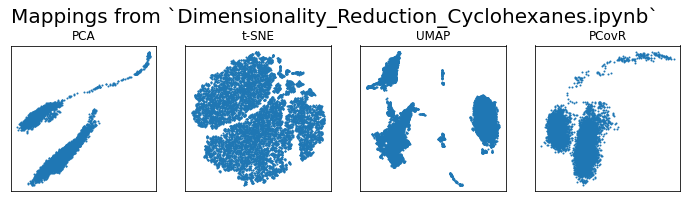

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for ax, rep, rep_name in zip(axes, [t_pca, t_tsne, t_umap, t_pcovr],
                             ['PCA', 't-SNE', 'UMAP', "PCovR"]):

    ax.scatter(
        rep[:, 0],
        rep[:, 1],
        s=1,
    )

    ax.set_title(rep_name, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(top=0.8)
plt.suptitle('Mappings from `Dimensionality_Reduction_Cyclohexanes.ipynb`')
plt.show()

## Clustering

In [5]:
def plot_clusters(algorithms,
                  algorithm_names=[''],
                  reps=[mean_soaps, t_pca, t_tsne, t_umap, t_pcovr],
                  rep_names=[
                      'SOAP Vectors\n(Plotted along PC1&2)', 'PCA', 't-SNE',
                      'UMAP', "PCovR"
                  ],
                  algorithm_kw={},
                  min_points=100,
                  savename=None):
    all_labels = {}

    if len(reps) > 1:
        fig, axes = plt.subplots(len(algorithms),
                                 len(reps),
                                 figsize=(len(reps) * 5, len(algorithms) * 5))
    elif len(algorithms) > 1:
        fig, axes = plt.subplots(1,
                                 len(algorithms),
                                 figsize=(len(algorithms) * 5, 5))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(6, 8))
        axes = np.array([axes])

    axes = np.reshape(axes, (len(algorithms), len(reps)))

    for axl, clustering_algorithm, cam_name, kwds in zip(
            axes, algorithms, algorithm_names, algorithm_kw):
        for ax, rep, rep_name in zip(axl, reps, rep_names):
            alg = clustering_algorithm(**kwds)
            raw_labels = alg.fit_predict(rep).tolist()

            u_labels = list(
                sorted(np.unique(raw_labels),
                       key=lambda l: -raw_labels.count(l)))
            np.maximum(raw_labels, 0)

            if len(u_labels) > 6:
                labels = [
                    u_labels.index(n) +
                    1 if raw_labels.count(n) > min_points else 0
                    for n in raw_labels
                ]
            else:
                labels = raw_labels
            nclusters = len(np.unique(labels))

            all_labels[(rep_name, cam_name)] = labels

            if nclusters < 256:
                if nclusters < 10:
                    cmap = plt.get_cmap('tab10')
                elif nclusters < 20:
                    cmap = plt.get_cmap('tab20')
                else:
                    cmap = plt.get_cmap('magma')
                norm = mpl.colors.BoundaryNorm(
                    np.arange(-0.5, nclusters + 0.5), cmap.N)
            else:
                cmap = plt.get_cmap('magma')
                norm = mpl.colors.BoundaryNorm(np.arange(0, 256), cmap.N)

            ax.scatter(
                rep[:, 0] if 'SOAP' not in rep_name else t_pca[:, 0],
                rep[:, 1] if 'SOAP' not in rep_name else t_pca[:, 1],
                s=2,
                c=labels,
                cmap=cmap,
                norm=norm,
                alpha=0.5,
            )

            plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                         ax=ax,
                         orientation='horizontal',
                         ticks=range(0, nclusters)[::max(1, nclusters // 10)])

            if len(algorithms) == 1:
                ax.set_title(rep_name, fontsize=12)
                fig.suptitle(algorithm_names[0])

            elif len(reps) == 1:
                ax.set_title(cam_name, fontsize=12)

                fig.suptitle(rep_name)
            else:
                ax.set_title((rep_name, cam_name), fontsize=12)

            ax.set_xticks([])
            ax.set_yticks([])

    fig.subplots_adjust(top=0.8)

    return all_labels

### K-Means on all Embeddings

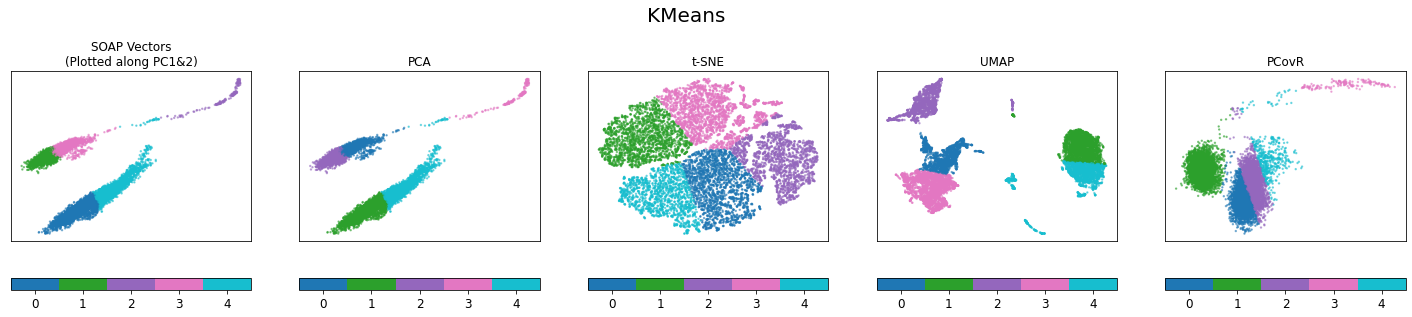

In [6]:
km_labels = plot_clusters([cluster.KMeans], ['KMeans'], algorithm_kw=[dict(n_clusters=5)])

### Comparing Clusterings of the t-SNE Embedding

From here on, we'll just work with the t-SNE map, but you can swap it out to see other results!

We will also assume that a "ground truth" clustering is based upon our similarities generated in the previous notebook.

(-89.17145036957149, 93.38216232437304, -92.33277653828846, 90.25314884425181)

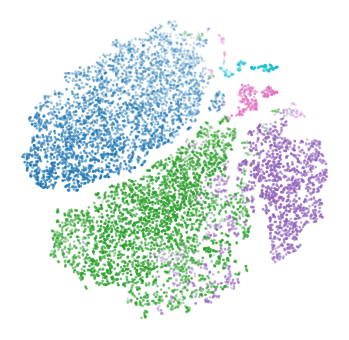

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(t_tsne[:, 0],
            t_tsne[:, 1],
            c=truth_labels,
            s=3,
            cmap='tab10',
            norm=mpl.colors.BoundaryNorm(np.arange(-0.5, 5.5), 10),
            alpha = np.max(sims, axis=1) ** 0.75,
           )
plt.gca().axis('off')

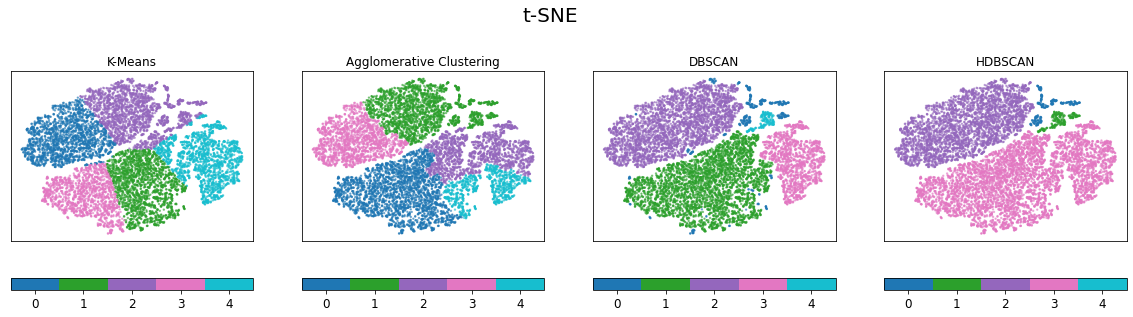

In [8]:
all_labels = plot_clusters([
    cluster.KMeans, cluster.AgglomerativeClustering, cluster.DBSCAN,
    hdbscan.HDBSCAN
], ["K-Means", 'Agglomerative Clustering', "DBSCAN", "HDBSCAN"],
                           algorithm_kw=[
                               dict(n_clusters=5),
                               dict(n_clusters=5),
                               dict(eps=2.5, min_samples=3),
                               dict(min_cluster_size=100, min_samples=1)
                           ],
                           reps=[t_tsne],
                           rep_names=['t-SNE'],
    min_points = 100,
)

In [9]:
scores = np.array([[
    davies_bouldin_score(mean_soaps,
                         np.array(labels).flatten()),
    silhouette_score(mean_soaps,
                     np.array(labels).flatten()),
    rand_score(truth_labels,
               np.array(labels).flatten()),
    fowlkes_mallows_score(truth_labels,
                          np.array(labels).flatten()),
    jaccard_score(truth_labels, np.array(labels).flatten(), average='macro'),
    f1_score(truth_labels, np.array(labels).flatten(), average='macro'),
] for labels in all_labels.values()])

In [10]:
df = pd.DataFrame(scores,
                  columns=["DB", "Silhouette", "Rand", "FM", "Jaccard", "F"],
                  index=all_labels.keys())
df.style.format(precision=2)

From here, we can see that HDBSCAN and DBSCAN best capture the shape of the data (seen by the low Davies-Bouldin and higher silhouette scores). Because we are using HDBSCAN as our "ground truth", the external metrics are high (Rand, Fowlkes-Mallows, Jaccard, and F-scores), with DBSCAN coming in second place.

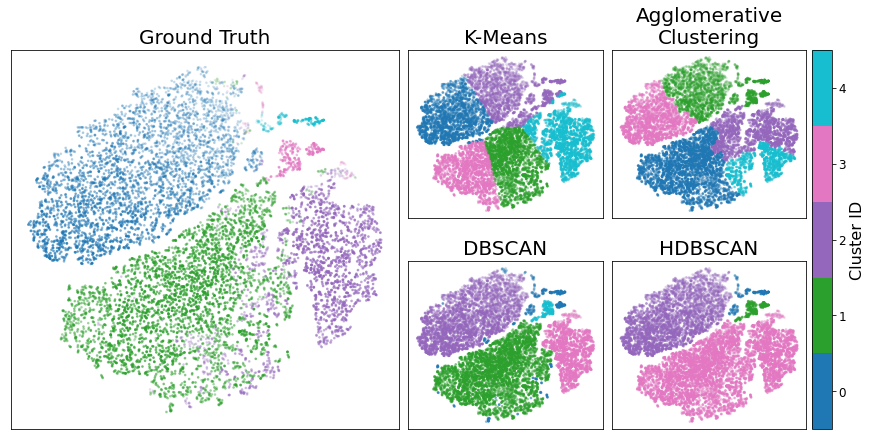

In [11]:
axd = plt.figure(constrained_layout=True, figsize=(12, 6)).subplot_mosaic(
    """
    ABCF
    ADEF
    """,
    gridspec_kw={
        "width_ratios": [2, 1, 1, 0.1],
    },
)

ax_labels = {
    "A": {"clusters": truth_labels, "Name":"Ground Truth"},
    "B": {"clusters": all_labels[('t-SNE', 'K-Means')], "Name": "K-Means"},
    "C": {"clusters": all_labels[('t-SNE', 'Agglomerative Clustering')], "Name": "Agglomerative\nClustering"},
    "D": {"clusters": all_labels[('t-SNE', 'DBSCAN')], "Name": "DBSCAN"},
    "E": {"clusters": all_labels[('t-SNE', 'HDBSCAN')], "Name": "HDBSCAN"}
}

norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 5.5), 10)
cmap = 'tab10'
for k, val in ax_labels.items():
    p = axd[k].scatter(
        t_tsne[:, 0],
        t_tsne[:, 1],
        c=val['clusters'],
        s=3,
        cmap=cmap,
        norm=norm,
        alpha=np.max(sims, axis=1)**0.75,
    )
    axd[k].set_xticks([])
    axd[k].set_yticks([])
    axd[k].set_title(val['Name'], fontsize=20)

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                         cax=axd['F'],
                         orientation='vertical',
             label='Cluster ID',
                         ticks=range(0, 5))

plt.savefig('./figures/Figure7.png')